# DNAme deconvolution benchmarking notebook 

Load in software packages and functions

In [1]:
source('./Scripts/LoadSoftware.r')
source('./Scripts/MarkerSelection.r')

Loading required package: Matrix

Loaded glmnet 4.1-4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:Matrix’:

    expand, unname


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package

Load in datasets for marker selection, deconvolution and true proportions

In [2]:
ref_path = './Demo_dataset/test_reference_dataset.csv'
val_path = './Demo_dataset/test_validation_dataset.csv'
props_path = './Demo_dataset/proportions.csv'

In [3]:
ref = read.csv(ref_path, row.names = 1)
rows = rownames(ref)
cols = colnames(ref)
ref = apply(ref, 2, as.numeric)
rownames(ref) = rows
colnames(ref) = cols
val = read.csv(val_path, row.names = 1)
rows = rownames(val)
cols = colnames(val)
val = apply(val, 2, as.numeric)
rownames(val) = rows
colnames(val) = cols
props = read.csv(props_path, row.names = 1)

Perform marker selection with 100 loci per cell type and P-value threshold of 0.05

In [4]:
celltypes = colnames(ref)
for(i in colnames(props)){
    celltypes[grepl(i, celltypes)] = i
}

output_selection = identifyCpgs(ref, celltypes, 0.05, 100)
mcpgs = unique(output_selection$cpgs)

Generate and store normalized reference and validation matrices

In [5]:
dataset = ref
normalizations <- c('none', 'z_score', 'min_max', 'col_z_score', 'col_min_max', 'QN', 'lognorm')
for (u in normalizations){
  if(u == 'none'){
    #None
    method <- 'none'
    normaliz <- function(x){
      return(x)
    }
    
  }else if (u == 'z_score'){
    #Z-score
    method = 'z_score'
    normaliz <- function(x){
      return((x-mean(na.omit(x)))/sd(na.omit(x)))
    }
    
  } else if (u == 'min_max'){
    #Min-max
    method <- 'min_max'
    normaliz <- function(x){
      return((x-min(na.omit(x)))/(max(na.omit(x))-min(na.omit(x))))
    }
    
  } else if (u == 'col_z_score'){
    #Column Z-score
    method <- 'col_z_score'
    normaliz <- function(x){
      cols <-function(y){
        return((y-mean(na.omit(y)))/sd(na.omit(y)))
        
      }
      apply(x, 2, cols)
      
    }
    
  } else if (u == 'col_min_max'){
    #Column min-max
    method <- 'col_min_max'
    
    normaliz <- function(x){
      cols <-function(y){
        return((y-min(na.omit(y)))/(max(na.omit(y)-min(na.omit(y)))))
        
      }
      apply(x, 2, cols)
      
    }
    
  } else if (u == 'QN'){
    #Quantile normalization
    
    method <- 'QN'
    normaliz <- function(x){
      x <- na.omit(x)
      rows <- rownames(x)
      cols <- colnames(x)
      x <- normalize.quantiles(x)
      rownames(x) <- rows
      colnames(x) <- cols
      return(x)
    }
    #
  }  else if (u == 'lognorm'){
    method <- 'lognorm'
    normaliz <- function(x){
      x <- log(na.omit(x))
      x[abs(x)==Inf] <- NA
      return(na.omit(x))
      
    }
  }
  tmp_dataset <- normaliz(dataset)
  ref <- matrix(NA, ncol = length(unique(celltypes)), nrow = length(mcpgs))
  colnames(ref) <- unique(celltypes)
  rownames(ref) <- mcpgs
  for(i in colnames(ref)){
    ref[,i] <- apply(tmp_dataset[mcpgs, celltypes == i], 1, mean)
  }
  write.csv(unique(na.omit(ref)), paste0('Cache/', method, '_reference.csv'))
}

In [6]:
dataset = val
normalizations <- c('none', 'z_score', 'min_max', 'col_z_score', 'col_min_max', 'QN', 'lognorm')
for (u in normalizations){
  if(u == 'none'){
    #None
    method <- 'none'
    normaliz <- function(x){
      return(x)
    }
    
  }else if (u == 'z_score'){
    #Z-score
    method = 'z_score'
    normaliz <- function(x){
      return((x-mean(na.omit(x)))/sd(na.omit(x)))
    }
    
  } else if (u == 'min_max'){
    #Min-max
    method <- 'min_max'
    normaliz <- function(x){
      return((x-min(na.omit(x)))/(max(na.omit(x))-min(na.omit(x))))
    }
    
  } else if (u == 'col_z_score'){
    #Column Z-score
    method <- 'col_z_score'
    normaliz <- function(x){
      cols <-function(y){
        return((y-mean(na.omit(y)))/sd(na.omit(y)))
        
      }
      apply(x, 2, cols)
      
    }
    
  } else if (u == 'col_min_max'){
    #Column min-max
    method <- 'col_min_max'
    
    normaliz <- function(x){
      cols <-function(y){
        return((y-min(na.omit(y)))/(max(na.omit(y)-min(na.omit(y)))))
        
      }
      apply(x, 2, cols)
      
    }
    
  } else if (u == 'QN'){
    #Quantile normalization
    
    method <- 'QN'
    normaliz <- function(x){
      x <- na.omit(x)
      rows <- rownames(x)
      cols <- colnames(x)
      x <- normalize.quantiles(x)
      rownames(x) <- rows
      colnames(x) <- cols
      return(x)
    }
    #
  }  else if (u == 'lognorm'){
    method <- 'lognorm'
    normaliz <- function(x){
      x <- log(na.omit(x))
      x[abs(x)==Inf] <- NA
      return(na.omit(x))
      
    }
  }
  tmp_dataset <- normaliz(dataset)
  
  
  write.csv(unique(na.omit(tmp_dataset[mcpgs,])), paste0('Cache/', method, '_mixture.csv'))
}

Perform Meth atlas deconvolution (python package)

In [7]:
system("python ./Scripts/PerformMethatlas.py")

Prepare dataframe for storing deconvolution results

In [8]:
longlist = matrix(NA, nrow =1, ncol = 5)
colnames(longlist) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
props = props[,colnames(ref)]

Run deconvolutions for all other deconvolution methods and normalization methods

In [9]:
for (method in normalizations){
  
  df <- read.csv(paste0('Cache/',method, '_mixture.csv'), row.names = 1)
  ref <- read.csv(paste0('Cache/', method, '_reference.csv'), row.names = 1)
  ref <- ref[rownames(df),]
  

  #EMeth-Normal-----
  deconv = 'emeth_normal'
  maximum_nu = 0
  maximum_iter = 50
  predicted_cell_proportions <- matrix(NA, ncol = dim(props)[2], nrow = dim(props)[1])
  predicted_cell_proportions <- emeth(Y = as.matrix(df[rownames(ref),]),eta = c(rep(0, dim(as.matrix(df[rownames(ref),]))[2])), mu = as.matrix(ref), aber = FALSE, V = 'c',init = "default", family = "normal", nu = maximum_nu, maxiter = maximum_iter, verbose = TRUE)$rho
  colnames(predicted_cell_proportions) <- colnames(props)
  rownames(predicted_cell_proportions) <- rownames(props)
  
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, predicted_cell_proportions[i,])}
  x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
  x[,1] <- unlist(l)
  x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
  x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
  x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])
  
  colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, props[i,])}
  x[,2] <- unlist(l)
  longlist <- rbind(longlist, x)
  
  #EMeth-Laplace-----
  deconv = 'emeth_laplace'
  predicted_cell_proportions <- matrix(NA, ncol = dim(props)[2], nrow = dim(props)[1])
  predicted_cell_proportions <- emeth(Y = as.matrix(df[rownames(ref),]),eta = c(rep(0, dim(as.matrix(df[rownames(ref),]))[2])), mu = as.matrix(ref), aber = FALSE, V = 'c',init = "default", family = "laplace", nu = maximum_nu, maxiter = maximum_iter, verbose = TRUE)$rho
  colnames(predicted_cell_proportions) <- colnames(props)
  rownames(predicted_cell_proportions) <- rownames(props)
  
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, predicted_cell_proportions[i,])}
  x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
  x[,1] <- unlist(l)
  x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
  x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
  x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])
  
  colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, props[i,])}
  x[,2] <- unlist(l)
  longlist <- rbind(longlist, x)
  
  
  #EMeth-Binom-----
  deconv = 'emeth_binom'
  predicted_cell_proportions <- matrix(NA, ncol = dim(props)[2], nrow = dim(props)[1])
  predicted_cell_proportions <- emeth(Y = as.matrix(df[rownames(ref),]),eta = c(rep(0, dim(as.matrix(df[rownames(ref),]))[2])), mu = as.matrix(ref), aber = FALSE, V = 'b',init = "default", family = "normal", nu = maximum_nu, maxiter = maximum_iter, verbose = TRUE)$rho
  colnames(predicted_cell_proportions) <- colnames(props)
  rownames(predicted_cell_proportions) <- rownames(props)
  
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, predicted_cell_proportions[i,])}
  x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
  x[,1] <- unlist(l)
  x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
  x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
  x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])
  
  colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, props[i,])}
  x[,2] <- unlist(l)
  longlist <- rbind(longlist, x)
  
  
  #NNLS------
  deconv = 'nnls'
  predicted_cell_proportions <- matrix(NA, ncol = dim(props)[2], nrow = dim(props)[1])
  for (i in 1:dim(props)[1]){
    predicted_cell_proportions[i,] <- coef(nnls(as.matrix(ref), df[rownames(ref),i]))
  }
  colnames(predicted_cell_proportions) <- colnames(props)
  rownames(predicted_cell_proportions) <- rownames(props)
  
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, predicted_cell_proportions[i,])}
  x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
  x[,1] <- unlist(l)
  x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
  x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
  x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])
  
  colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, props[i,])}
  x[,2] <- unlist(l)
  longlist <- rbind(longlist, x)
  
  
  #BVLS------
  deconv = 'bvls'
  predicted_cell_proportions <- matrix(NA, ncol = dim(props)[2], nrow = dim(props)[1])
  for (i in 1:dim(props)[1]){
    predicted_cell_proportions[i,] <- coef(bvls(as.matrix(ref), df[rownames(ref),i], bl = c(rep(0, dim(ref)[2])), bu = c(rep(1, dim(ref)[2]))))
  }
  colnames(predicted_cell_proportions) <- colnames(props)
  rownames(predicted_cell_proportions) <- rownames(props)
  
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, predicted_cell_proportions[i,])}
  x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
  x[,1] <- unlist(l)
  x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
  x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
  x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])
  
  colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, props[i,])}
  x[,2] <- unlist(l)
  longlist <- rbind(longlist, x)
  
  #EpiDISH------
  deconv = 'epidish'
  predicted_cell_proportions <- matrix(NA, ncol = dim(props)[2], nrow = dim(props)[1])
  predicted_cell_proportions <- epidish(as.matrix(df), as.matrix(ref))$estF
  colnames(predicted_cell_proportions) <- colnames(props)
  rownames(predicted_cell_proportions) <- rownames(props)
  
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, predicted_cell_proportions[i,])}
  x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
  x[,1] <- unlist(l)
  x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
  x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
  x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])
  l <- c()
  colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, props[i,])}
  x[,2] <- unlist(l)
  longlist <- rbind(longlist, x)
  
  
  #Minfi------
  deconv = 'minfi'
  predicted_cell_proportions <- projectCellType(Y = as.matrix(df[rownames(ref),]), coefCellType = as.matrix(ref))
  colnames(predicted_cell_proportions) <- colnames(props)
  rownames(predicted_cell_proportions) <- rownames(props)
  
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, predicted_cell_proportions[i,])}
  x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
  x[,1] <- unlist(l)
  x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
  x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
  x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])
  
  colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, props[i,])}
  x[,2] <- unlist(l)
  longlist <- rbind(longlist, x)
  
  
  #MethylResolver------
  deconv = 'methylresolver'
  methylMix <- as.data.frame(df[rownames(ref),])
  methylSig <- as.data.frame(ref)
  regressionFormula = as.formula(paste0("methylMix[,i] ~ ",paste(colnames(ref),sep="",collapse=" + ")))
  preds <- matrix(NA, ncol = length(colnames(ref)), nrow = length(colnames(df)))
  colnames(preds) <- colnames(ref)
  rownames(preds) <- colnames(df)
  j = 1
  for (i in colnames(df)){
    deconvoluteSample <- robustbase::ltsReg(regressionFormula, data = methylSig, alpha = 0.5)
    preds[j,] <- deconvoluteSample$coefficients[2:length(deconvoluteSample$coefficients)]
    j <- j+1
  }
  predicted_cell_proportions <- preds
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, predicted_cell_proportions[i,])}
  x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
  x[,1] <- unlist(l)
  x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
  x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
  x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])
  
  colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
  
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, props[i,])}
  x[,2] <- unlist(l)
  longlist <- rbind(longlist, x)
  
  #Meth_atlas------
  deconv = 'meth_atlas'
  predicted_cell_proportions <- read.csv(paste0('Cache/',method, '_results_meth_atl.csv'))
  rownames(predicted_cell_proportions) <- predicted_cell_proportions$X
  predicted_cell_proportions$X <- NULL
  
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, predicted_cell_proportions[i,])}
  x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
  x[,1] <- unlist(l)
  x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
  x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
  x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])
  
  colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, props[i,])}
  x[,2] <- unlist(l)
  longlist <- rbind(longlist, x)
  
  #OLS------
  deconv = 'ols'
  m <- matrix(NA, nrow = dim(df)[2], ncol  = dim(ref)[2])
  colnames(m) <- colnames(ref)
  rownames(m) <- colnames(df)
  cmd = 'lm(formula = df[rownames(ref),i] ~ 0'
  for(i in colnames(ref)){
  cmd = paste0(cmd, paste0(' + ref[,"',i, '"]'))
  }
  cmd = paste0(cmd, ')')
  for (i in 1:dim(df)[2]){
    model <- eval(parse(text = cmd))
    m[i,] <- unlist(lapply(model$coefficients, function (x) x/sum(model$coefficients)))
  }
  m[m<0] <- 0.00000001
  predicted_cell_proportions <- m
  
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, predicted_cell_proportions[i,])}
  x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
  x[,1] <- unlist(l)
  x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
  x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
  x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])
  
  colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, props[i,])}
  x[,2] <- unlist(l)
  longlist <- rbind(longlist, x)
  
  #Ridge------
  deconv = 'ridge'
  m <- matrix(NA, nrow = dim(df)[2], ncol  = dim(ref)[2])
  colnames(m) <- colnames(ref)
  rownames(m) <- colnames(df)
  for (i in 1:dim(df)[2]){
    mod <- glmnet(x = as.matrix(ref),y=df[rownames(ref), i], alpha = 0)
    mod <- glmnet(x = as.matrix(ref),y=df[rownames(ref), i], alpha = 0, lambda = mod$lambda[which(mod$dev.ratio == max(mod$dev.ratio))])
    m[i,] <- coef(mod)[2:length(coef(mod))]
  }
  m[m<0] <- 0.00000001
  predicted_cell_proportions <- m
  
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, predicted_cell_proportions[i,])}
  x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
  x[,1] <- unlist(l)
  x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
  x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
  x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])
  
  colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, props[i,])}
  x[,2] <- unlist(l)
  longlist <- rbind(longlist, x)
  
  #Elastic net------
  deconv = 'elastic_net'
  m <- matrix(NA, nrow = dim(df)[2], ncol  = dim(ref)[2])
  colnames(m) <- colnames(ref)
  rownames(m) <- colnames(df)
  for (i in 1:dim(df)[2]){
    mod <- glmnet(x = as.matrix(ref),y=df[rownames(ref), i], alpha = 0.5)
    mod <- glmnet(x = as.matrix(ref),y=df[rownames(ref), i], alpha = 0.5, lambda = mod$lambda[which(mod$dev.ratio == max(mod$dev.ratio))])
    m[i,] <- coef(mod)[2:length(coef(mod))]
  }
  m[m<0] <- 0.00000001
  predicted_cell_proportions <- m
  
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, predicted_cell_proportions[i,])}
  x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
  x[,1] <- unlist(l)
  x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
  x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
  x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])
  
  colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, props[i,])}
  x[,2] <- unlist(l)
  longlist <- rbind(longlist, x)
  
  #Lasso------
  deconv = 'lasso'
  m <- matrix(NA, nrow = dim(df)[2], ncol  = dim(ref)[2])
  colnames(m) <- colnames(ref)
  rownames(m) <- colnames(df)
  for (i in 1:dim(df)[2]){
    mod <- glmnet(x = as.matrix(ref),y=df[rownames(ref), i], alpha = 1)
    mod <- glmnet(x = as.matrix(ref),y=df[rownames(ref), i], alpha = 1, lambda = mod$lambda[which(mod$dev.ratio == max(mod$dev.ratio))])
    m[i,] <- coef(mod)[2:length(coef(mod))]
  }
  m[m<0] <- 0.00000001
  predicted_cell_proportions <- m
  
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, predicted_cell_proportions[i,])}
  x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
  x[,1] <- unlist(l)
  x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
  x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
  x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])
  
  colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
  l <- c()
  for(i in 1:dim(predicted_cell_proportions)[1]){
    l<- c(l, props[i,])}
  x[,2] <- unlist(l)
  longlist <- rbind(longlist, x)
                           
  #ICeDT------
    if(!method%in%c('z_score', 'lognorm', 'col_z_score')){
    deconv = 'icedt'

    predicted_cell_proportions <- as.data.frame(t(ICeDT(as.matrix(df[rownames(ref),]), as.matrix(ref), rhoConverge = 0.0015, maxIter_PP = 30)$rho))[,colnames(props)]

      l <- c()
      for(i in 1:dim(predicted_cell_proportions)[1]){
        l<- c(l, predicted_cell_proportions[i,])}
      x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
      x[,1] <- unlist(l)
      x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
      x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
      x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])

      colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
      l <- c()
      for(i in 1:dim(predicted_cell_proportions)[1]){
        l<- c(l, props[i,])}
      x[,2] <- unlist(l)
      longlist <- rbind(longlist, x)
    }
    
    #FARDEEP------
    deconv = 'fardeep'

    predicted_cell_proportions <- as.data.frame(fardeep(as.matrix(ref),as.matrix(df[rownames(ref),]))$abs.beta)[,colnames(props)]

      l <- c()
      for(i in 1:dim(predicted_cell_proportions)[1]){
        l<- c(l, predicted_cell_proportions[i,])}
      x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
      x[,1] <- unlist(l)
      x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
      x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
      x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])

      colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
      l <- c()
      for(i in 1:dim(predicted_cell_proportions)[1]){
        l<- c(l, props[i,])}
      x[,2] <- unlist(l)
      longlist <- rbind(longlist, x)

    #DCQ------
    deconv = 'dcq'

    predicted_cell_proportions <- as.data.frame(t(estCellPercent.DCQ(refExpr=as.matrix(ref), geneExpr=as.matrix(df[rownames(ref),]))))[,colnames(props)]/100

      l <- c()
      for(i in 1:dim(predicted_cell_proportions)[1]){
        l<- c(l, predicted_cell_proportions[i,])}
      x <- matrix(NA, nrow = length(unlist(l)), ncol = 5)
      x[,1] <- unlist(l)
      x[,3] <- rep(colnames(props), dim(predicted_cell_proportions)[1])
      x[,4] <- rep(method, dim(predicted_cell_proportions)[1])
      x[,5] <- rep(deconv, dim(predicted_cell_proportions)[1])

      colnames(x) <- c('Predicted value', 'True value','Celltype', 'Normalization method', 'Deconvolution method')
      l <- c()
      for(i in 1:dim(predicted_cell_proportions)[1]){
        l<- c(l, props[i,])}
      x[,2] <- unlist(l)
      longlist <- rbind(longlist, x)
}
longlist = as.data.frame(longlist[-1,])


-------------------
10 Thu Feb  8 11:19:37 2024 
-------------------
10 Thu Feb  8 11:19:41 2024 
-------------------
20 Thu Feb  8 11:19:46 2024 
-------------------
30 Thu Feb  8 11:19:50 2024 
-------------------
40 Thu Feb  8 11:19:54 2024 
-------------------
50 Thu Feb  8 11:19:58 2024 


Iter 1: max diff of rho: 0.0422333363314462

.
.
.
.
.
.


-------------------
10 Thu Feb  8 11:20:27 2024 
-------------------
20 Thu Feb  8 11:20:29 2024 
-------------------
30 Thu Feb  8 11:20:30 2024 
-------------------
10 Thu Feb  8 11:20:34 2024 
-------------------
20 Thu Feb  8 11:20:38 2024 
-------------------
30 Thu Feb  8 11:20:43 2024 
-------------------
40 Thu Feb  8 11:20:47 2024 
-------------------
50 Thu Feb  8 11:20:51 2024 
-------------------
10 Thu Feb  8 11:20:53 2024 
-------------------
20 Thu Feb  8 11:20:54 2024 
-------------------
10 Thu Feb  8 11:21:05 2024 
-------------------
10 Thu Feb  8 11:21:10 2024 
-------------------
20 Thu Feb  8 11:21:14 2024 
-------------------
30 Thu Feb  8 11:21:19 2024 
-------------------
40 Thu Feb  8 11:21:23 2024 
-------------------
50 Thu Feb  8 11:21:28 2024 


Iter 1: max diff of rho: 0.0442702300793624

.
.
.
.
.
.


-------------------
10 Thu Feb  8 11:21:57 2024 
-------------------
10 Thu Feb  8 11:22:01 2024 
-------------------
20 Thu Feb  8 11:22:05 2024 
-------------------
30 Thu Feb  8 11:22:10 2024 
-------------------
40 Thu Feb  8 11:22:14 2024 
-------------------
50 Thu Feb  8 11:22:18 2024 
-------------------
10 Thu Feb  8 11:22:20 2024 
-------------------
10 Thu Feb  8 11:22:32 2024 
-------------------
10 Thu Feb  8 11:22:37 2024 
-------------------
20 Thu Feb  8 11:22:41 2024 
-------------------
30 Thu Feb  8 11:22:46 2024 
-------------------
40 Thu Feb  8 11:22:50 2024 
-------------------
50 Thu Feb  8 11:22:55 2024 


Iter 1: max diff of rho: 0.0387140200418202

.
.
.
.
.


-------------------
10 Thu Feb  8 11:23:21 2024 
-------------------
10 Thu Feb  8 11:23:26 2024 
-------------------
20 Thu Feb  8 11:23:31 2024 
-------------------
30 Thu Feb  8 11:23:35 2024 
-------------------
40 Thu Feb  8 11:23:40 2024 
-------------------
50 Thu Feb  8 11:23:44 2024 


Iter 1: max diff of rho: 0.0261634722160939

.
.
.
.


-------------------
10 Thu Feb  8 11:24:07 2024 
-------------------
20 Thu Feb  8 11:24:08 2024 
-------------------
30 Thu Feb  8 11:24:10 2024 
-------------------
40 Thu Feb  8 11:24:11 2024 
-------------------
50 Thu Feb  8 11:24:12 2024 
-------------------
10 Thu Feb  8 11:24:16 2024 
-------------------
20 Thu Feb  8 11:24:21 2024 
-------------------
30 Thu Feb  8 11:24:26 2024 
-------------------
40 Thu Feb  8 11:24:31 2024 
-------------------
50 Thu Feb  8 11:24:35 2024 
-------------------
10 Thu Feb  8 11:24:37 2024 
-------------------
20 Thu Feb  8 11:24:38 2024 
-------------------
30 Thu Feb  8 11:24:40 2024 
-------------------
40 Thu Feb  8 11:24:41 2024 
-------------------
50 Thu Feb  8 11:24:42 2024 


Store compiled matrix of all deconvolutions

In [10]:
write.csv(longlist, 'Deconvolution_results.csv')

Visualize one algorithm-normalization combination in a scatter plot

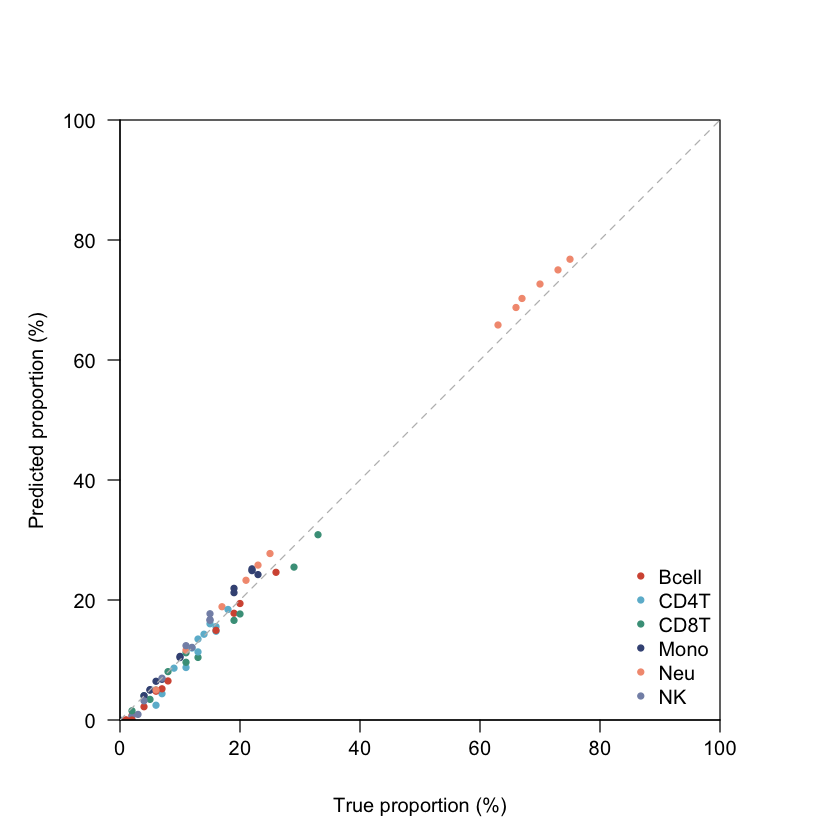

In [11]:
par(mar = c(5, 5, 5, 5))
mycolors <- c('#D55740', '#6CB9D2', '#479E88', '#415384', '#F39B7FFF','#8491B4FF')
names(mycolors) <- c('Bcell', 'CD4T', 'CD8T', 'Mono', 'Neu', 'NK')
plot(x =as.numeric(longlist[longlist$`Normalization method` == 'none' & longlist$`Deconvolution method` == 'epidish' ,]$`True value`)*100,
         y = as.numeric(longlist[longlist$`Normalization method` == 'none' & longlist$`Deconvolution method` == 'epidish',]$`Predicted value`)*100,
        col = mycolors[longlist[longlist$`Normalization method` == 'none' & longlist$`Deconvolution method` == 'epidish',]$Celltype],
         xlab='True proportion (%)',
         ylab = 'Predicted proportion (%)',
         pch = 20,
         xlim = c(0, 100),
         ylim = c(0, 100),
         xaxs="i",
         yaxs="i",
         las = 1,
         xaxt = 'n',
         yaxt = 'n'
        )
axis(1,  seq(0, 100, 20),  cex.axis = 0.5, tck = -0.02, labels = FALSE)
axis(2,  seq(0, 100, 20), las = 2, tck = -0.02)
text(x = seq(0, 100, 20),y = par("usr")[3]-4.5,labels = as.character(seq(0, 100, 20)),xpd = NA)
lines(x = seq(0, 100,1), y = seq(0, 100, 1), type = 'l', lty = 2, col = 'gray')
legend('bottomright', legend = names(mycolors), col = mycolors, pch = 20, bty = 'n')